In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, f1_score, mean_squared_error
from scipy.stats import gmean, kde
import scipy.stats as st

import time
from scipy.stats import ttest_ind

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from prettytable import PrettyTable

In [5]:
import performances_evaluation

In [6]:
from multiprocessing import Pool
from functools import partial

In [7]:
import smote_cd

# Definition of the functions

In [8]:
def display_r2_errorbar(imbalance_ratio_tot, r2_raw_tot, r2_compositional_tot, r2_logratio_tot,
                    r2_raw_std, r2_compositional_std, r2_logratio_std, size_sample, n_features, n_classes, title=None):
    
    plt.figure(figsize=(10,6))
    plt.errorbar(np.array(imbalance_ratio_tot),np.mean(r2_raw_tot,axis=1),2*np.array(np.mean(r2_raw_std,axis=1))/np.sqrt(size_sample),label='raw')
    plt.errorbar(np.array(imbalance_ratio_tot),np.mean(r2_compositional_tot,axis=1),2*np.array(np.mean(r2_compositional_std,axis=1))/np.sqrt(size_sample),label='compositional')
    plt.errorbar(np.array(imbalance_ratio_tot),np.mean(r2_logratio_tot,axis=1),2*np.array(np.mean(r2_logratio_std,axis=1))/np.sqrt(size_sample),label='logratio')
    plt.xlabel('% of class 0')
    plt.ylabel('R2 score')
    plt.legend()
    if title is None:
        plt.title('R2 score, depending on the imbalance of the train set, with ' + str(n_features) + ' features and ' + str(n_classes) + ' classes')
    else:
        plt.title(title)
    plt.show()

In [9]:
def display_f1_errorbar(imbalance_ratio_tot, f1_raw_tot, f1_compositional_tot, f1_logratio_tot,
                    f1_raw_std, f1_compositional_std, f1_logratio_std, size_sample, n_features, n_classes, title=None):
    
    plt.figure(figsize=(10,6))
    plt.errorbar(np.array(imbalance_ratio_tot),np.mean(f1_raw_tot,axis=1),2*np.array(np.mean(f1_raw_std,axis=1))/np.sqrt(size_sample),label='raw')
    plt.errorbar(np.array(imbalance_ratio_tot),np.mean(f1_compositional_tot,axis=1),2*np.array(np.mean(f1_compositional_std,axis=1))/np.sqrt(size_sample),label='compositional')
    plt.errorbar(np.array(imbalance_ratio_tot),np.mean(f1_logratio_tot,axis=1),2*np.array(np.mean(f1_logratio_std,axis=1))/np.sqrt(size_sample),label='logratio')
    plt.xlabel('% of class 0')
    plt.ylabel('F1 score')
    plt.legend()
    if title is None:
        plt.title('F1 score, depending on the imbalance of the train set, with ' + str(n_features) + ' features and ' + str(n_classes) + ' classes')
    else:
        plt.title(title)
    plt.show()

In [10]:
def display_accuracy_errorbar(imbalance_ratio_tot, accuracy_raw_tot, accuracy_compositional_tot, accuracy_logratio_tot,
                    accuracy_raw_std, accuracy_compositional_std, accuracy_logratio_std, size_sample, n_features, n_classes, title=None):
    
    plt.figure(figsize=(10,6))
    plt.errorbar(np.array(imbalance_ratio_tot),accuracy_raw_tot,2*np.array(accuracy_raw_std)/np.sqrt(size_sample),label='raw')
    plt.errorbar(np.array(imbalance_ratio_tot),accuracy_compositional_tot,2*np.array(accuracy_compositional_std)/np.sqrt(size_sample),label='compositional')
    plt.errorbar(np.array(imbalance_ratio_tot),accuracy_logratio_tot,2*np.array(accuracy_logratio_std)/np.sqrt(size_sample),label='logratio')
    plt.xlabel('% of class 0')
    plt.ylabel('Accuracy')
    plt.legend()
    if title is None:
        plt.title('Accuracy, depending on the imbalance of the train set, with ' + str(n_features) + ' features and ' + str(n_classes) + ' classes')
    else:
        plt.title(title)
    plt.show()

--- 
# SAME SHAPE AS REAL DATA

In [11]:
n_features=16
n_classes=4
size_sample=550
betas=smote_cd.dataset_generation.generate_betas(n_features,n_classes,random_state=10)

betas[0,0] = 0.1
betas[0,2] = 0.2

betas[1,1] = 0.1
betas[1,2] = 0.05
betas[1,4] = 0.7
betas[1,7] = 0.9
betas[1,8] = 0.4

betas[2,0] = 6
betas[2,1] = 2
betas[2,2] = -6
betas[2,4] = 2
betas[2,10] = -2
betas[2,11] = -14
betas[2,12] = 10
betas[2,13] = 8
betas[2,14] = -12
betas[2,15] = -8

betas[3,5] = 6
betas[3,6] = -4
betas[3,7] = 8
betas[3,8] = -8
betas[3,9] = 8

X,y,_=smote_cd.dataset_generation.generate_dataset(n_features,n_classes,size_sample,betas=betas,random_state=2)

In [12]:
sum(y)/np.sum(y)

array([0.15775842, 0.08138106, 0.43761829, 0.32324223])

## Gradient Boosting

In [23]:
%%time
    
list_iter = np.arange(100)
with Pool(10) as pool:
    all_res_parallel_gb = pool.map(partial(performances_evaluation.perf_evaluation_gb_parallel, n_features=n_features, n_classes=n_classes, size_sample=size_sample, betas_init=betas, n_imbalanced_points=1), list_iter)
    

Wall time: 4min 27s


In [24]:
r2_compositional_tot_gb, r2_raw_tot_gb, r2_logratio_tot_gb = [],[],[]
logloss_compositional_tot_gb, logloss_raw_tot_gb, logloss_logratio_tot_gb = [], [], []
rmse_compositional_tot_gb, rmse_raw_tot_gb, rmse_logratio_tot_gb = [], [], []
accuracy_compositional_tot_gb, accuracy_raw_tot_gb, accuracy_logratio_tot_gb = [], [], []
f1_compositional_tot_gb, f1_raw_tot_gb, f1_logratio_tot_gb = [], [], []
imbalance_ratio_tot_gb=[]

r2_compositional_std_gb, r2_raw_std_gb, r2_logratio_std_gb = [], [], []
logloss_compositional_std_gb, logloss_raw_std_gb, logloss_logratio_std_gb = [], [], []
rmse_compositional_std_gb, rmse_raw_std_gb, rmse_logratio_std_gb = [], [], []
accuracy_compositional_std_gb, accuracy_raw_std_gb, accuracy_logratio_std_gb = [], [], []
f1_compositional_std_gb, f1_raw_std_gb, f1_logratio_std_gb = [], [], []
imbalance_ratio_std_gb=[]

r2_compositional, r2_raw, r2_logratio = [], [], []
logloss_compositional, logloss_raw, logloss_logratio = [], [], []
rmse_compositional, rmse_raw, rmse_logratio = [], [], []
accuracy_compositional, accuracy_raw, accuracy_logratio = [], [], []
f1_compositional, f1_raw, f1_logratio = [], [], []
imbalance_ratio = []

In [25]:
for i in range(len(all_res_parallel_gb)):
    r2_compositional_temp, r2_raw_temp, r2_logratio_temp, logloss_compositional_temp, logloss_raw_temp, logloss_logratio_temp, rmse_compositional_temp, rmse_raw_temp, rmse_logratio_temp, accuracy_compositional_temp, accuracy_raw_temp, accuracy_logratio_temp, f1_compositional_temp, f1_raw_temp, f1_logratio_temp, imbalance_ratio_temp = all_res_parallel_gb[i]
    r2_compositional.append(np.round(np.mean(r2_compositional_temp,axis=0),5))
    r2_raw.append(np.round(np.mean(r2_raw_temp,axis=0),5))
    r2_logratio.append(np.round(np.mean(r2_logratio_temp,axis=0),5))
    logloss_compositional.append(np.round(np.mean(logloss_compositional_temp),5))
    logloss_raw.append(np.round(np.mean(logloss_raw_temp),5))
    logloss_logratio.append(np.round(np.mean(logloss_logratio_temp),5))
    rmse_compositional.append(np.round(np.mean(rmse_compositional_temp),5))
    rmse_raw.append(np.round(np.mean(rmse_raw_temp),5))
    rmse_logratio.append(np.round(np.mean(rmse_logratio_temp),5))
    accuracy_compositional.append(np.round(np.mean(accuracy_compositional_temp),5))
    accuracy_raw.append(np.round(np.mean(accuracy_raw_temp),5))
    accuracy_logratio.append(np.round(np.mean(accuracy_logratio_temp),5))
    f1_compositional.append(np.round(np.mean(f1_compositional_temp,axis=0),5))
    f1_raw.append(np.round(np.mean(f1_raw_temp,axis=0),5))
    f1_logratio.append(np.round(np.mean(f1_logratio_temp,axis=0),5))
    imbalance_ratio.append(np.round(np.mean(imbalance_ratio_temp),5))

r2_compositional_tot_gb.append(np.round(np.mean(r2_compositional,axis=0),5))
r2_raw_tot_gb.append(np.round(np.mean(r2_raw,axis=0),5))
r2_logratio_tot_gb.append(np.round(np.mean(r2_logratio,axis=0),5))
logloss_compositional_tot_gb.append(np.round(np.mean(logloss_compositional),5))
logloss_raw_tot_gb.append(np.round(np.mean(logloss_raw),5))
logloss_logratio_tot_gb.append(np.round(np.mean(logloss_logratio),5))
rmse_compositional_tot_gb.append(np.round(np.mean(rmse_compositional),5))
rmse_raw_tot_gb.append(np.round(np.mean(rmse_raw),5))
rmse_logratio_tot_gb.append(np.round(np.mean(rmse_logratio),5))
accuracy_compositional_tot_gb.append(np.round(np.mean(accuracy_compositional),5))
accuracy_raw_tot_gb.append(np.round(np.mean(accuracy_raw),5))
accuracy_logratio_tot_gb.append(np.round(np.mean(accuracy_logratio),5))
f1_compositional_tot_gb.append(np.round(np.mean(f1_compositional,axis=0),5))
f1_raw_tot_gb.append(np.round(np.mean(f1_raw,axis=0),5))
f1_logratio_tot_gb.append(np.round(np.mean(f1_logratio,axis=0),5))
imbalance_ratio_tot_gb.append(np.round(np.mean(imbalance_ratio),5))

r2_compositional_std_gb.append(np.round(np.std(r2_compositional,axis=0),5))
r2_raw_std_gb.append(np.round(np.std(r2_raw,axis=0),5))
r2_logratio_std_gb.append(np.round(np.std(r2_logratio,axis=0),5))
logloss_compositional_std_gb.append(np.round(np.std(logloss_compositional),5))
logloss_raw_std_gb.append(np.round(np.std(logloss_raw),5))
logloss_logratio_std_gb.append(np.round(np.std(logloss_logratio),5))
rmse_compositional_std_gb.append(np.round(np.std(rmse_compositional),5))
rmse_raw_std_gb.append(np.round(np.std(rmse_raw),5))
rmse_logratio_std_gb.append(np.round(np.std(rmse_logratio),5))
accuracy_compositional_std_gb.append(np.round(np.std(accuracy_compositional),5))
accuracy_raw_std_gb.append(np.round(np.std(accuracy_raw),5))
accuracy_logratio_std_gb.append(np.round(np.std(accuracy_logratio),5))
f1_compositional_std_gb.append(np.round(np.std(f1_compositional,axis=0),5))
f1_raw_std_gb.append(np.round(np.std(f1_raw,axis=0),5))
f1_logratio_std_gb.append(np.round(np.std(f1_logratio,axis=0),5))
imbalance_ratio_std_gb.append(np.round(np.std(imbalance_ratio),5))

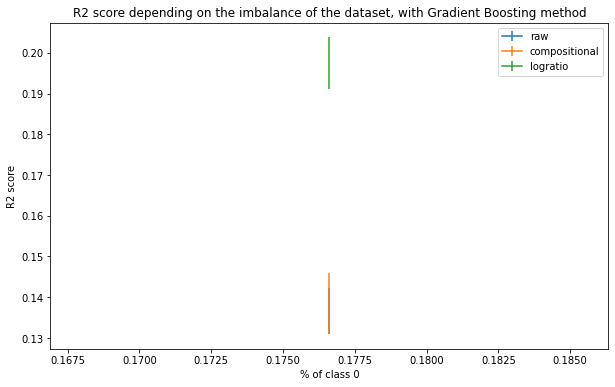

In [33]:
title='R2 score depending on the imbalance of the dataset, with Gradient Boosting method'
display_r2_errorbar(imbalance_ratio_tot_gb, r2_raw_tot_gb, r2_compositional_tot_gb, r2_logratio_tot_gb,
                    r2_raw_std_gb, r2_compositional_std_gb, r2_logratio_std_gb, size_sample, n_features, n_classes, title=title)

In [31]:
columns_names = ['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2']
rows_names = ['Raw', 'Compositional', 'Logratio']

pt = PrettyTable(['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2'])
pt.title = 'RESULTS ON SYNTHETIC DATA WITH GRADIENT BOOSTING TREE'
pt.add_row(['Raw',accuracy_raw_tot_gb[0], logloss_raw_tot_gb[0], np.round(np.mean(f1_raw_tot_gb),3), rmse_raw_tot_gb[0], np.round(np.mean(r2_raw_tot_gb),3)])
pt.add_row(['Compositional',accuracy_compositional_tot_gb[0], logloss_compositional_tot_gb[0], np.round(np.mean(f1_compositional_tot_gb),3), rmse_compositional_tot_gb[0], np.round(np.mean(r2_compositional_tot_gb),3)])
pt.add_row(['Logratio',accuracy_logratio_tot_gb[0], logloss_logratio_tot_gb[0], np.round(np.mean(f1_logratio_tot_gb),3), rmse_logratio_tot_gb[0], np.round(np.mean(r2_logratio_tot_gb),3)])

print(pt)

+-----------------------------------------------------------------------+
|         RESULTS ON SYNTHETIC DATA WITH GRADIENT BOOSTING TREE         |
+---------------+----------+---------------+----------+---------+-------+
|     Model     | Accuracy | Cross-entropy | F1-score |   RMSE  |   R2  |
+---------------+----------+---------------+----------+---------+-------+
|      Raw      | 0.69212  |    5.27227    |  0.532   | 0.36346 | 0.137 |
| Compositional | 0.68265  |    3.65742    |  0.604   | 0.35924 | 0.139 |
|    Logratio   | 0.72445  |    2.50775    |  0.658   | 0.34098 | 0.198 |
+---------------+----------+---------------+----------+---------+-------+


In [32]:
columns_names = ['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2']
rows_names = ['Raw', 'Compositional', 'Logratio']

pt = PrettyTable(['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2'])
pt.title = 'STD ON SYNTHETIC DATA WITH GRADIENT BOOSTING TREE'
pt.add_row(['Raw',accuracy_raw_std_gb[0], logloss_raw_std_gb[0], np.round(np.mean(f1_raw_std_gb),3), rmse_raw_std_gb[0], np.round(np.mean(r2_raw_std_gb),3)])
pt.add_row(['Compositional',accuracy_compositional_std_gb[0], logloss_compositional_std_gb[0], np.round(np.mean(f1_compositional_std_gb),3), rmse_compositional_std_gb[0], np.round(np.mean(r2_compositional_std_gb),3)])
pt.add_row(['Logratio',accuracy_logratio_std_gb[0], logloss_logratio_std_gb[0], np.round(np.mean(f1_logratio_std_gb),3), rmse_logratio_std_gb[0], np.round(np.mean(r2_logratio_std_gb),3)])

print(pt)

+-----------------------------------------------------------------------+
|           STD ON SYNTHETIC DATA WITH GRADIENT BOOSTING TREE           |
+---------------+----------+---------------+----------+---------+-------+
|     Model     | Accuracy | Cross-entropy | F1-score |   RMSE  |   R2  |
+---------------+----------+---------------+----------+---------+-------+
|      Raw      | 0.01793  |    1.53893    |  0.045   | 0.01139 | 0.067 |
| Compositional | 0.01627  |    1.05549    |  0.038   | 0.01068 | 0.085 |
|    Logratio   | 0.01665  |    0.55349    |  0.027   | 0.01139 | 0.074 |
+---------------+----------+---------------+----------+---------+-------+


### T-tests

In [41]:
print('Accuracy raw-compositional',ttest_ind(accuracy_raw,accuracy_compositional))
print('Accuracy raw-logratio',ttest_ind(accuracy_raw,accuracy_logratio))

print('Crossentropy raw-compositional',ttest_ind(logloss_raw,logloss_compositional))
print('Crossentropy raw-logratio',ttest_ind(logloss_raw,logloss_logratio))

print('RMSE raw-compositional',ttest_ind(rmse_raw,rmse_compositional))
print('RMSE raw-logratio',ttest_ind(rmse_raw,rmse_logratio))

print('R2 raw-compositional',ttest_ind(np.mean(r2_raw,axis=1),np.mean(r2_compositional,axis=1)))
print('R2 raw-logratio',ttest_ind(np.mean(r2_raw,axis=1),np.mean(r2_logratio,axis=1)))

print('F1 raw-compositional',ttest_ind(np.mean(f1_raw,axis=1),np.mean(f1_compositional,axis=1)))
print('F1 raw-logratio',ttest_ind(np.mean(f1_raw,axis=1),np.mean(f1_logratio,axis=1)))

Accuracy raw-compositional Ttest_indResult(statistic=3.8938196715776057, pvalue=0.00013485160145677825)
Accuracy raw-logratio Ttest_indResult(statistic=-13.145720331626258, pvalue=8.714901608765723e-29)
Crossentropy raw-compositional Ttest_indResult(statistic=8.61021551532408, pvalue=2.2692816181999927e-15)
Crossentropy raw-logratio Ttest_indResult(statistic=16.81914518441003, pvalue=5.1839573344394646e-40)
RMSE raw-compositional Ttest_indResult(statistic=2.688169462071678, pvalue=0.007796355052157189)
RMSE raw-logratio Ttest_indResult(statistic=13.884097276450502, pvalue=4.722311008824813e-31)
R2 raw-compositional Ttest_indResult(statistic=-0.3976775663573896, pvalue=0.6912962813100233)
R2 raw-logratio Ttest_indResult(statistic=-8.686838967627308, pvalue=1.3941323081796108e-15)
F1 raw-compositional Ttest_indResult(statistic=-21.90577422518123, pvalue=8.203257580010736e-55)
F1 raw-logratio Ttest_indResult(statistic=-41.16552694185088, pvalue=5.221759279349832e-99)


## Dirichlet

In [39]:
%%time
    
list_iter = np.arange(100)
with Pool(10) as pool:
    all_res_parallel_dirichlet = pool.map(partial(performances_evaluation.perf_evaluation_dirichlet_parallel, n_features=n_features, n_classes=n_classes, size_sample=size_sample, betas_init=betas, n_imbalanced_points=1), list_iter)
    

Wall time: 8min 43s


In [42]:
r2_compositional_tot_dirichlet, r2_raw_tot_dirichlet, r2_logratio_tot_dirichlet = [],[],[]
logloss_compositional_tot_dirichlet, logloss_raw_tot_dirichlet, logloss_logratio_tot_dirichlet = [], [], []
rmse_compositional_tot_dirichlet, rmse_raw_tot_dirichlet, rmse_logratio_tot_dirichlet = [], [], []
accuracy_compositional_tot_dirichlet, accuracy_raw_tot_dirichlet, accuracy_logratio_tot_dirichlet = [], [], []
f1_compositional_tot_dirichlet, f1_raw_tot_dirichlet, f1_logratio_tot_dirichlet = [], [], []
imbalance_ratio_tot_dirichlet=[]

r2_compositional_std_dirichlet, r2_raw_std_dirichlet, r2_logratio_std_dirichlet = [], [], []
logloss_compositional_std_dirichlet, logloss_raw_std_dirichlet, logloss_logratio_std_dirichlet = [], [], []
rmse_compositional_std_dirichlet, rmse_raw_std_dirichlet, rmse_logratio_std_dirichlet = [], [], []
accuracy_compositional_std_dirichlet, accuracy_raw_std_dirichlet, accuracy_logratio_std_dirichlet = [], [], []
f1_compositional_std_dirichlet, f1_raw_std_dirichlet, f1_logratio_std_dirichlet = [], [], []
imbalance_ratio_std_dirichlet=[]

r2_compositional, r2_raw, r2_logratio = [], [], []
logloss_compositional, logloss_raw, logloss_logratio = [], [], []
rmse_compositional, rmse_raw, rmse_logratio = [], [], []
accuracy_compositional, accuracy_raw, accuracy_logratio = [], [], []
f1_compositional, f1_raw, f1_logratio = [], [], []
imbalance_ratio = []

In [43]:
for i in range(len(all_res_parallel_dirichlet)):
    r2_compositional_temp, r2_raw_temp, r2_logratio_temp, logloss_compositional_temp, logloss_raw_temp, logloss_logratio_temp, rmse_compositional_temp, rmse_raw_temp, rmse_logratio_temp, accuracy_compositional_temp, accuracy_raw_temp, accuracy_logratio_temp, f1_compositional_temp, f1_raw_temp, f1_logratio_temp, imbalance_ratio_temp = all_res_parallel_dirichlet[i]
    r2_compositional.append(np.round(np.mean(r2_compositional_temp,axis=0),5))
    r2_raw.append(np.round(np.mean(r2_raw_temp,axis=0),5))
    r2_logratio.append(np.round(np.mean(r2_logratio_temp,axis=0),5))
    logloss_compositional.append(np.round(np.mean(logloss_compositional_temp),5))
    logloss_raw.append(np.round(np.mean(logloss_raw_temp),5))
    logloss_logratio.append(np.round(np.mean(logloss_logratio_temp),5))
    rmse_compositional.append(np.round(np.mean(rmse_compositional_temp),5))
    rmse_raw.append(np.round(np.mean(rmse_raw_temp),5))
    rmse_logratio.append(np.round(np.mean(rmse_logratio_temp),5))
    accuracy_compositional.append(np.round(np.mean(accuracy_compositional_temp),5))
    accuracy_raw.append(np.round(np.mean(accuracy_raw_temp),5))
    accuracy_logratio.append(np.round(np.mean(accuracy_logratio_temp),5))
    f1_compositional.append(np.round(np.mean(f1_compositional_temp,axis=0),5))
    f1_raw.append(np.round(np.mean(f1_raw_temp,axis=0),5))
    f1_logratio.append(np.round(np.mean(f1_logratio_temp,axis=0),5))
    imbalance_ratio.append(np.round(np.mean(imbalance_ratio_temp),5))

r2_compositional_tot_dirichlet.append(np.round(np.mean(r2_compositional,axis=0),5))
r2_raw_tot_dirichlet.append(np.round(np.mean(r2_raw,axis=0),5))
r2_logratio_tot_dirichlet.append(np.round(np.mean(r2_logratio,axis=0),5))
logloss_compositional_tot_dirichlet.append(np.round(np.mean(logloss_compositional),5))
logloss_raw_tot_dirichlet.append(np.round(np.mean(logloss_raw),5))
logloss_logratio_tot_dirichlet.append(np.round(np.mean(logloss_logratio),5))
rmse_compositional_tot_dirichlet.append(np.round(np.mean(rmse_compositional),5))
rmse_raw_tot_dirichlet.append(np.round(np.mean(rmse_raw),5))
rmse_logratio_tot_dirichlet.append(np.round(np.mean(rmse_logratio),5))
accuracy_compositional_tot_dirichlet.append(np.round(np.mean(accuracy_compositional),5))
accuracy_raw_tot_dirichlet.append(np.round(np.mean(accuracy_raw),5))
accuracy_logratio_tot_dirichlet.append(np.round(np.mean(accuracy_logratio),5))
f1_compositional_tot_dirichlet.append(np.round(np.mean(f1_compositional,axis=0),5))
f1_raw_tot_dirichlet.append(np.round(np.mean(f1_raw,axis=0),5))
f1_logratio_tot_dirichlet.append(np.round(np.mean(f1_logratio,axis=0),5))
imbalance_ratio_tot_dirichlet.append(np.round(np.mean(imbalance_ratio),5))

r2_compositional_std_dirichlet.append(np.round(np.std(r2_compositional,axis=0),5))
r2_raw_std_dirichlet.append(np.round(np.std(r2_raw,axis=0),5))
r2_logratio_std_dirichlet.append(np.round(np.std(r2_logratio,axis=0),5))
logloss_compositional_std_dirichlet.append(np.round(np.std(logloss_compositional),5))
logloss_raw_std_dirichlet.append(np.round(np.std(logloss_raw),5))
logloss_logratio_std_dirichlet.append(np.round(np.std(logloss_logratio),5))
rmse_compositional_std_dirichlet.append(np.round(np.std(rmse_compositional),5))
rmse_raw_std_dirichlet.append(np.round(np.std(rmse_raw),5))
rmse_logratio_std_dirichlet.append(np.round(np.std(rmse_logratio),5))
accuracy_compositional_std_dirichlet.append(np.round(np.std(accuracy_compositional),5))
accuracy_raw_std_dirichlet.append(np.round(np.std(accuracy_raw),5))
accuracy_logratio_std_dirichlet.append(np.round(np.std(accuracy_logratio),5))
f1_compositional_std_dirichlet.append(np.round(np.std(f1_compositional,axis=0),5))
f1_raw_std_dirichlet.append(np.round(np.std(f1_raw,axis=0),5))
f1_logratio_std_dirichlet.append(np.round(np.std(f1_logratio,axis=0),5))
imbalance_ratio_std_dirichlet.append(np.round(np.std(imbalance_ratio),5))

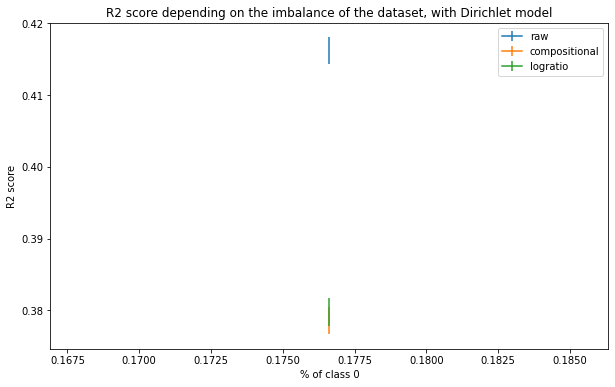

In [49]:
title='R2 score depending on the imbalance of the dataset, with Dirichlet model'
display_r2_errorbar(imbalance_ratio_tot_dirichlet, r2_raw_tot_dirichlet, r2_compositional_tot_dirichlet, r2_logratio_tot_dirichlet,
                    r2_raw_std_dirichlet, r2_compositional_std_dirichlet, r2_logratio_std_dirichlet, size_sample, n_features, n_classes, title=title)

In [44]:
columns_names = ['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2']
rows_names = ['Raw', 'Compositional', 'Logratio']

pt = PrettyTable(['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2'])
pt.title = 'RESULTS ON SYNTHETIC DATA WITH DIRICHLET MODEL'
pt.add_row(['Raw',accuracy_raw_tot_dirichlet[0], logloss_raw_tot_dirichlet[0], np.round(np.mean(f1_raw_tot_dirichlet),3), rmse_raw_tot_dirichlet[0], np.round(np.mean(r2_raw_tot_dirichlet),3)])
pt.add_row(['Compositional',accuracy_compositional_tot_dirichlet[0], logloss_compositional_tot_dirichlet[0], np.round(np.mean(f1_compositional_tot_dirichlet),3), rmse_compositional_tot_dirichlet[0], np.round(np.mean(r2_compositional_tot_dirichlet),3)])
pt.add_row(['Logratio',accuracy_logratio_tot_dirichlet[0], logloss_logratio_tot_dirichlet[0], np.round(np.mean(f1_logratio_tot_dirichlet),3), rmse_logratio_tot_dirichlet[0], np.round(np.mean(r2_logratio_tot_dirichlet),3)])

print(pt)

+-----------------------------------------------------------------------+
|             RESULTS ON SYNTHETIC DATA WITH DIRICHLET MODEL            |
+---------------+----------+---------------+----------+---------+-------+
|     Model     | Accuracy | Cross-entropy | F1-score |   RMSE  |   R2  |
+---------------+----------+---------------+----------+---------+-------+
|      Raw      | 0.78893  |    0.68509    |  0.605   | 0.28721 | 0.416 |
| Compositional | 0.87441  |    0.75465    |  0.824   | 0.30319 | 0.379 |
|    Logratio   | 0.87453  |    0.75426    |  0.824   |  0.3031 |  0.38 |
+---------------+----------+---------------+----------+---------+-------+


In [45]:
columns_names = ['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2']
rows_names = ['Raw', 'Compositional', 'Logratio']

pt = PrettyTable(['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2'])
pt.title = 'STD ON SYNTHETIC DATA WITH DIRICHLET MODEL'
pt.add_row(['Raw',accuracy_raw_std_dirichlet[0], logloss_raw_std_dirichlet[0], np.round(np.mean(f1_raw_std_dirichlet),3), rmse_raw_std_dirichlet[0], np.round(np.mean(r2_raw_std_dirichlet),3)])
pt.add_row(['Compositional',accuracy_compositional_std_dirichlet[0], logloss_compositional_std_dirichlet[0], np.round(np.mean(f1_compositional_std_dirichlet),3), rmse_compositional_std_dirichlet[0], np.round(np.mean(r2_compositional_std_dirichlet),3)])
pt.add_row(['Logratio',accuracy_logratio_std_dirichlet[0], logloss_logratio_std_dirichlet[0], np.round(np.mean(f1_logratio_std_dirichlet),3), rmse_logratio_std_dirichlet[0], np.round(np.mean(r2_logratio_std_dirichlet),3)])

print(pt)

+-----------------------------------------------------------------------+
|               STD ON SYNTHETIC DATA WITH DIRICHLET MODEL              |
+---------------+----------+---------------+----------+---------+-------+
|     Model     | Accuracy | Cross-entropy | F1-score |   RMSE  |   R2  |
+---------------+----------+---------------+----------+---------+-------+
|      Raw      | 0.01608  |    0.01722    |  0.039   | 0.00369 | 0.022 |
| Compositional | 0.01064  |    0.01716    |  0.019   | 0.00402 | 0.022 |
|    Logratio   | 0.01048  |    0.01727    |  0.019   | 0.00405 | 0.022 |
+---------------+----------+---------------+----------+---------+-------+


### T-tests

In [46]:
print('Accuracy raw-compositional',ttest_ind(accuracy_raw,accuracy_compositional))
print('Accuracy raw-logratio',ttest_ind(accuracy_raw,accuracy_logratio))

print('Crossentropy raw-compositional',ttest_ind(logloss_raw,logloss_compositional))
print('Crossentropy raw-logratio',ttest_ind(logloss_raw,logloss_logratio))

print('RMSE raw-compositional',ttest_ind(rmse_raw,rmse_compositional))
print('RMSE raw-logratio',ttest_ind(rmse_raw,rmse_logratio))

print('R2 raw-compositional',ttest_ind(np.mean(r2_raw,axis=1),np.mean(r2_compositional,axis=1)))
print('R2 raw-logratio',ttest_ind(np.mean(r2_raw,axis=1),np.mean(r2_logratio,axis=1)))

print('F1 raw-compositional',ttest_ind(np.mean(f1_raw,axis=1),np.mean(f1_compositional,axis=1)))
print('F1 raw-logratio',ttest_ind(np.mean(f1_raw,axis=1),np.mean(f1_logratio,axis=1)))

Accuracy raw-compositional Ttest_indResult(statistic=-44.10882239063126, pvalue=2.2947891843388123e-104)
Accuracy raw-logratio Ttest_indResult(statistic=-44.370350685009946, pvalue=7.922616057051856e-105)
Crossentropy raw-compositional Ttest_indResult(statistic=-28.466460236670944, pvalue=6.498133747974196e-72)
Crossentropy raw-logratio Ttest_indResult(statistic=-28.217318325709055, pvalue=2.6300249293743257e-71)
RMSE raw-compositional Ttest_indResult(statistic=-29.165305220095423, pvalue=1.339241082204275e-73)
RMSE raw-logratio Ttest_indResult(statistic=-28.862826676929018, pvalue=7.136361762656766e-73)
R2 raw-compositional Ttest_indResult(statistic=19.025763781629777, pvalue=1.4041775425678957e-46)
R2 raw-logratio Ttest_indResult(statistic=18.920813916252733, pvalue=2.851863664952149e-46)
F1 raw-compositional Ttest_indResult(statistic=-82.04902173423687, pvalue=7.875770160196499e-155)
F1 raw-logratio Ttest_indResult(statistic=-82.9061672452444, pvalue=1.0660664063225966e-155)


## Neural Network

In [40]:
%%time
    
list_iter = np.arange(100)
with Pool(10) as pool:
    all_res_parallel_nn = pool.map(partial(performances_evaluation.perf_evaluation_nn_parallel, n_features=n_features, n_classes=n_classes, size_sample=size_sample, betas_init=betas, n_imbalanced_points=1), list_iter)
    

Wall time: 14min 56s


In [47]:
r2_compositional_tot_nn, r2_raw_tot_nn, r2_logratio_tot_nn = [],[],[]
logloss_compositional_tot_nn, logloss_raw_tot_nn, logloss_logratio_tot_nn = [], [], []
rmse_compositional_tot_nn, rmse_raw_tot_nn, rmse_logratio_tot_nn = [], [], []
accuracy_compositional_tot_nn, accuracy_raw_tot_nn, accuracy_logratio_tot_nn = [], [], []
f1_compositional_tot_nn, f1_raw_tot_nn, f1_logratio_tot_nn = [], [], []
imbalance_ratio_tot_nn=[]

r2_compositional_std_nn, r2_raw_std_nn, r2_logratio_std_nn = [], [], []
logloss_compositional_std_nn, logloss_raw_std_nn, logloss_logratio_std_nn = [], [], []
rmse_compositional_std_nn, rmse_raw_std_nn, rmse_logratio_std_nn = [], [], []
accuracy_compositional_std_nn, accuracy_raw_std_nn, accuracy_logratio_std_nn = [], [], []
f1_compositional_std_nn, f1_raw_std_nn, f1_logratio_std_nn = [], [], []
imbalance_ratio_std_nn=[]

r2_compositional, r2_raw, r2_logratio = [], [], []
logloss_compositional, logloss_raw, logloss_logratio = [], [], []
rmse_compositional, rmse_raw, rmse_logratio = [], [], []
accuracy_compositional, accuracy_raw, accuracy_logratio = [], [], []
f1_compositional, f1_raw, f1_logratio = [], [], []
imbalance_ratio = []

In [48]:
for i in range(len(all_res_parallel_nn)):
    r2_compositional_temp, r2_raw_temp, r2_logratio_temp, logloss_compositional_temp, logloss_raw_temp, logloss_logratio_temp, rmse_compositional_temp, rmse_raw_temp, rmse_logratio_temp, accuracy_compositional_temp, accuracy_raw_temp, accuracy_logratio_temp, f1_compositional_temp, f1_raw_temp, f1_logratio_temp, imbalance_ratio_temp = all_res_parallel_nn[i]
    r2_compositional.append(np.round(np.mean(r2_compositional_temp,axis=0),5))
    r2_raw.append(np.round(np.mean(r2_raw_temp,axis=0),5))
    r2_logratio.append(np.round(np.mean(r2_logratio_temp,axis=0),5))
    logloss_compositional.append(np.round(np.mean(logloss_compositional_temp),5))
    logloss_raw.append(np.round(np.mean(logloss_raw_temp),5))
    logloss_logratio.append(np.round(np.mean(logloss_logratio_temp),5))
    rmse_compositional.append(np.round(np.mean(rmse_compositional_temp),5))
    rmse_raw.append(np.round(np.mean(rmse_raw_temp),5))
    rmse_logratio.append(np.round(np.mean(rmse_logratio_temp),5))
    accuracy_compositional.append(np.round(np.mean(accuracy_compositional_temp),5))
    accuracy_raw.append(np.round(np.mean(accuracy_raw_temp),5))
    accuracy_logratio.append(np.round(np.mean(accuracy_logratio_temp),5))
    f1_compositional.append(np.round(np.mean(f1_compositional_temp,axis=0),5))
    f1_raw.append(np.round(np.mean(f1_raw_temp,axis=0),5))
    f1_logratio.append(np.round(np.mean(f1_logratio_temp,axis=0),5))
    imbalance_ratio.append(np.round(np.mean(imbalance_ratio_temp),5))

r2_compositional_tot_nn.append(np.round(np.mean(r2_compositional,axis=0),5))
r2_raw_tot_nn.append(np.round(np.mean(r2_raw,axis=0),5))
r2_logratio_tot_nn.append(np.round(np.mean(r2_logratio,axis=0),5))
logloss_compositional_tot_nn.append(np.round(np.mean(logloss_compositional),5))
logloss_raw_tot_nn.append(np.round(np.mean(logloss_raw),5))
logloss_logratio_tot_nn.append(np.round(np.mean(logloss_logratio),5))
rmse_compositional_tot_nn.append(np.round(np.mean(rmse_compositional),5))
rmse_raw_tot_nn.append(np.round(np.mean(rmse_raw),5))
rmse_logratio_tot_nn.append(np.round(np.mean(rmse_logratio),5))
accuracy_compositional_tot_nn.append(np.round(np.mean(accuracy_compositional),5))
accuracy_raw_tot_nn.append(np.round(np.mean(accuracy_raw),5))
accuracy_logratio_tot_nn.append(np.round(np.mean(accuracy_logratio),5))
f1_compositional_tot_nn.append(np.round(np.mean(f1_compositional,axis=0),5))
f1_raw_tot_nn.append(np.round(np.mean(f1_raw,axis=0),5))
f1_logratio_tot_nn.append(np.round(np.mean(f1_logratio,axis=0),5))
imbalance_ratio_tot_nn.append(np.round(np.mean(imbalance_ratio),5))

r2_compositional_std_nn.append(np.round(np.std(r2_compositional,axis=0),5))
r2_raw_std_nn.append(np.round(np.std(r2_raw,axis=0),5))
r2_logratio_std_nn.append(np.round(np.std(r2_logratio,axis=0),5))
logloss_compositional_std_nn.append(np.round(np.std(logloss_compositional),5))
logloss_raw_std_nn.append(np.round(np.std(logloss_raw),5))
logloss_logratio_std_nn.append(np.round(np.std(logloss_logratio),5))
rmse_compositional_std_nn.append(np.round(np.std(rmse_compositional),5))
rmse_raw_std_nn.append(np.round(np.std(rmse_raw),5))
rmse_logratio_std_nn.append(np.round(np.std(rmse_logratio),5))
accuracy_compositional_std_nn.append(np.round(np.std(accuracy_compositional),5))
accuracy_raw_std_nn.append(np.round(np.std(accuracy_raw),5))
accuracy_logratio_std_nn.append(np.round(np.std(accuracy_logratio),5))
f1_compositional_std_nn.append(np.round(np.std(f1_compositional,axis=0),5))
f1_raw_std_nn.append(np.round(np.std(f1_raw,axis=0),5))
f1_logratio_std_nn.append(np.round(np.std(f1_logratio,axis=0),5))
imbalance_ratio_std_nn.append(np.round(np.std(imbalance_ratio),5))

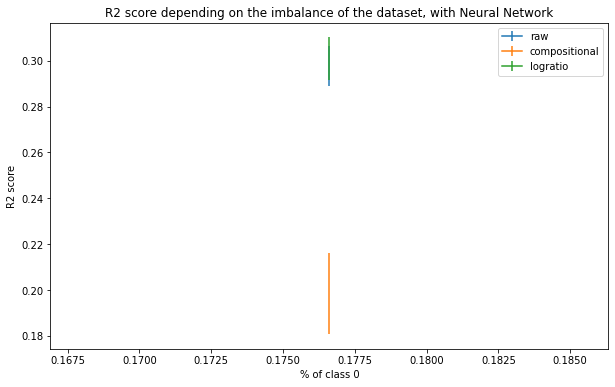

In [49]:
title='R2 score depending on the imbalance of the dataset, with Neural Network'
display_r2_errorbar(imbalance_ratio_tot_nn, r2_raw_tot_nn, r2_compositional_tot_nn, r2_logratio_tot_nn,
                    r2_raw_std_nn, r2_compositional_std_nn, r2_logratio_std_nn, size_sample, n_features, n_classes, title=title)

In [51]:
columns_names = ['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2']
rows_names = ['Raw', 'Compositional', 'Logratio']

pt = PrettyTable(['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2'])
pt.title = 'RESULTS ON SYNTHETIC DATA WITH NN'
pt.add_row(['Raw',accuracy_raw_tot_nn[0], logloss_raw_tot_nn[0], np.round(np.mean(f1_raw_tot_nn),3), rmse_raw_tot_nn[0], np.round(np.mean(r2_raw_tot_nn),3)])
pt.add_row(['Compositional',accuracy_compositional_tot_nn[0], logloss_compositional_tot_nn[0], np.round(np.mean(f1_compositional_tot_nn),3), rmse_compositional_tot_nn[0], np.round(np.mean(r2_compositional_tot_nn),3)])
pt.add_row(['Logratio',accuracy_logratio_tot_nn[0], logloss_logratio_tot_nn[0], np.round(np.mean(f1_logratio_tot_nn),3), rmse_logratio_tot_nn[0], np.round(np.mean(r2_logratio_tot_nn),3)])

print(pt)

+-----------------------------------------------------------------------+
|                   RESULTS ON SYNTHETIC DATA WITH NN                   |
+---------------+----------+---------------+----------+---------+-------+
|     Model     | Accuracy | Cross-entropy | F1-score |   RMSE  |   R2  |
+---------------+----------+---------------+----------+---------+-------+
|      Raw      | 0.77173  |    3.33955    |  0.611   | 0.31472 | 0.298 |
| Compositional |  0.7503  |    3.48307    |   0.69   | 0.33176 | 0.198 |
|    Logratio   | 0.78394  |    1.69978    |  0.729   |  0.3036 | 0.301 |
+---------------+----------+---------------+----------+---------+-------+


In [52]:
columns_names = ['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2']
rows_names = ['Raw', 'Compositional', 'Logratio']

pt = PrettyTable(['Model', 'Accuracy', 'Cross-entropy', 'F1-score', 'RMSE', 'R2'])
pt.title = 'STD ON SYNTHETIC DATA WITH NN'
pt.add_row(['Raw',accuracy_raw_std_nn[0], logloss_raw_std_nn[0], np.round(np.mean(f1_raw_std_nn),3), rmse_raw_std_nn[0], np.round(np.mean(r2_raw_std_nn),3)])
pt.add_row(['Compositional',accuracy_compositional_std_nn[0], logloss_compositional_std_nn[0], np.round(np.mean(f1_compositional_std_nn),3), rmse_compositional_std_nn[0], np.round(np.mean(r2_compositional_std_nn),3)])
pt.add_row(['Logratio',accuracy_logratio_std_nn[0], logloss_logratio_std_nn[0], np.round(np.mean(f1_logratio_std_nn),3), rmse_logratio_std_nn[0], np.round(np.mean(r2_logratio_std_nn),3)])

print(pt)

+-----------------------------------------------------------------------+
|                     STD ON SYNTHETIC DATA WITH NN                     |
+---------------+----------+---------------+----------+---------+-------+
|     Model     | Accuracy | Cross-entropy | F1-score |   RMSE  |   R2  |
+---------------+----------+---------------+----------+---------+-------+
|      Raw      | 0.02613  |    1.37027    |  0.057   | 0.02019 | 0.103 |
| Compositional | 0.05438  |    1.36703    |  0.063   | 0.03952 | 0.207 |
|    Logratio   | 0.02272  |    0.38027    |  0.033   |  0.018  | 0.108 |
+---------------+----------+---------------+----------+---------+-------+


### T-tests

In [53]:
print('Accuracy raw-compositional',ttest_ind(accuracy_raw,accuracy_compositional))
print('Accuracy raw-logratio',ttest_ind(accuracy_raw,accuracy_logratio))

print('Crossentropy raw-compositional',ttest_ind(logloss_raw,logloss_compositional))
print('Crossentropy raw-logratio',ttest_ind(logloss_raw,logloss_logratio))

print('RMSE raw-compositional',ttest_ind(rmse_raw,rmse_compositional))
print('RMSE raw-logratio',ttest_ind(rmse_raw,rmse_logratio))

print('R2 raw-compositional',ttest_ind(np.mean(r2_raw,axis=1),np.mean(r2_compositional,axis=1)))
print('R2 raw-logratio',ttest_ind(np.mean(r2_raw,axis=1),np.mean(r2_logratio,axis=1)))

print('F1 raw-compositional',ttest_ind(np.mean(f1_raw,axis=1),np.mean(f1_compositional,axis=1)))
print('F1 raw-logratio',ttest_ind(np.mean(f1_raw,axis=1),np.mean(f1_logratio,axis=1)))

Accuracy raw-compositional Ttest_indResult(statistic=3.5356455531759767, pvalue=0.0005064912297744419)
Accuracy raw-logratio Ttest_indResult(statistic=-3.507519287052775, pvalue=0.0005596371030311656)
Crossentropy raw-compositional Ttest_indResult(statistic=-0.7377446075700568, pvalue=0.4615430800140431)
Crossentropy raw-logratio Ttest_indResult(statistic=11.473181790728717, pvalue=1.0811408410745918e-23)
RMSE raw-compositional Ttest_indResult(statistic=-3.8195327124719585, pvalue=0.0001788580786160205)
RMSE raw-logratio Ttest_indResult(statistic=4.09142506314928, pvalue=6.236665617373786e-05)
R2 raw-compositional Ttest_indResult(statistic=4.912621528131687, pvalue=1.8782590251855947e-06)
R2 raw-logratio Ttest_indResult(statistic=-0.27068843423963845, pvalue=0.7869126359754411)
F1 raw-compositional Ttest_indResult(statistic=-11.93344592629649, pvalue=4.378355883264777e-25)
F1 raw-logratio Ttest_indResult(statistic=-26.8031615855558, pvalue=8.47828353808059e-68)


# Variating the beta

In [22]:
n_features=16
n_classes=4
size_sample=550
betas=dataset_generation.generate_betas(n_features,n_classes,random_state=4)
betas[0,0]=1

X,y,_=dataset_generation.generate_dataset(n_features,n_classes,size_sample,betas=betas,random_state=2)

In [45]:
%%time
outputs_dirichlet = performances_evaluation.perf_evaluation(n_features, n_classes, size_sample, betas, method='dirichlet', n_imbalanced_points=20, n_iter=100, step=2)

Wall time: 2h 4min 25s


In [46]:
np.save('Results/outputs_dirichlet.npy',np.array(outputs_dirichlet,dtype='object'))

In [47]:
%%time
outputs_gb = performances_evaluation.perf_evaluation(n_features, n_classes, size_sample, betas, method='gb', n_imbalanced_points=20, n_iter=100, step=2)

Wall time: 43min 56s


In [48]:
np.save('Results/outputs_gb.npy',np.array(outputs_gb,dtype='object'))

In [49]:
%%time
outputs_nn = performances_evaluation.perf_evaluation(n_features, n_classes, size_sample, betas, method='nn', n_imbalanced_points=20, n_iter=100, step=2)

Wall time: 4h 41min 10s


In [50]:
np.save('Results/outputs_nn.npy',np.array(outputs_nn,dtype='object'))

In [3]:
outputs_dirichlet = np.load('Results/outputs_dirichlet.npy', allow_pickle=True)
outputs_gb = np.load('Results/outputs_gb.npy', allow_pickle=True)
outputs_nn = np.load('Results/outputs_nn.npy', allow_pickle=True)

In [4]:
r2_compositional_tot_dirichlet=[]
r2_raw_tot_dirichlet=[]
r2_logratio_tot_dirichlet=[]

accuracy_compositional_tot_dirichlet=[]
accuracy_raw_tot_dirichlet=[]
accuracy_logratio_tot_dirichlet=[]

f1_compositional_tot_dirichlet=[]
f1_raw_tot_dirichlet=[]
f1_logratio_tot_dirichlet=[]

imbalance_ratio_tot_dirichlet=[]

r2_compositional_std_dirichlet=[]
r2_raw_std_dirichlet=[]
r2_logratio_std_dirichlet=[]

accuracy_compositional_std_dirichlet=[]
accuracy_raw_std_dirichlet=[]
accuracy_logratio_std_dirichlet=[]

f1_compositional_std_dirichlet=[]
f1_raw_std_dirichlet=[]
f1_logratio_std_dirichlet=[]

imbalance_ratio_std_dirichlet=[]

for output in outputs_dirichlet:
    r2_compositional_tot_dirichlet.append(output[0])
    r2_raw_tot_dirichlet.append(output[1])
    r2_logratio_tot_dirichlet.append(output[2])
    accuracy_compositional_tot_dirichlet.append(output[3])
    accuracy_raw_tot_dirichlet.append(output[4])
    accuracy_logratio_tot_dirichlet.append(output[5])

    f1_compositional_tot_dirichlet.append(output[6])
    f1_raw_tot_dirichlet.append(output[7])
    f1_logratio_tot_dirichlet.append(output[8])

    imbalance_ratio_tot_dirichlet.append(output[9])
    
    r2_compositional_std_dirichlet.append(output[10])
    r2_raw_std_dirichlet.append(output[11])
    r2_logratio_std_dirichlet.append(output[12])
    accuracy_compositional_std_dirichlet.append(output[13])
    accuracy_raw_std_dirichlet.append(output[14])
    accuracy_logratio_std_dirichlet.append(output[15])

    f1_compositional_std_dirichlet.append(output[16])
    f1_raw_std_dirichlet.append(output[17])
    f1_logratio_std_dirichlet.append(output[18])

    imbalance_ratio_std_dirichlet.append(output[19])

In [5]:
r2_compositional_tot_gb=[]
r2_raw_tot_gb=[]
r2_logratio_tot_gb=[]

accuracy_compositional_tot_gb=[]
accuracy_raw_tot_gb=[]
accuracy_logratio_tot_gb=[]

f1_compositional_tot_gb=[]
f1_raw_tot_gb=[]
f1_logratio_tot_gb=[]

imbalance_ratio_tot_gb=[]

r2_compositional_std_gb=[]
r2_raw_std_gb=[]
r2_logratio_std_gb=[]

accuracy_compositional_std_gb=[]
accuracy_raw_std_gb=[]
accuracy_logratio_std_gb=[]

f1_compositional_std_gb=[]
f1_raw_std_gb=[]
f1_logratio_std_gb=[]

imbalance_ratio_std_gb=[]

for output in outputs_gb:
    r2_compositional_tot_gb.append(output[0])
    r2_raw_tot_gb.append(output[1])
    r2_logratio_tot_gb.append(output[2])
    accuracy_compositional_tot_gb.append(output[3])
    accuracy_raw_tot_gb.append(output[4])
    accuracy_logratio_tot_gb.append(output[5])

    f1_compositional_tot_gb.append(output[6])
    f1_raw_tot_gb.append(output[7])
    f1_logratio_tot_gb.append(output[8])

    imbalance_ratio_tot_gb.append(output[9])
    
    r2_compositional_std_gb.append(output[10])
    r2_raw_std_gb.append(output[11])
    r2_logratio_std_gb.append(output[12])
    accuracy_compositional_std_gb.append(output[13])
    accuracy_raw_std_gb.append(output[14])
    accuracy_logratio_std_gb.append(output[15])

    f1_compositional_std_gb.append(output[16])
    f1_raw_std_gb.append(output[17])
    f1_logratio_std_gb.append(output[18])

    imbalance_ratio_std_gb.append(output[19])

In [6]:
r2_compositional_tot_nn=[]
r2_raw_tot_nn=[]
r2_logratio_tot_nn=[]

accuracy_compositional_tot_nn=[]
accuracy_raw_tot_nn=[]
accuracy_logratio_tot_nn=[]

f1_compositional_tot_nn=[]
f1_raw_tot_nn=[]
f1_logratio_tot_nn=[]

imbalance_ratio_tot_nn=[]

r2_compositional_std_nn=[]
r2_raw_std_nn=[]
r2_logratio_std_nn=[]

accuracy_compositional_std_nn=[]
accuracy_raw_std_nn=[]
accuracy_logratio_std_nn=[]

f1_compositional_std_nn=[]
f1_raw_std_nn=[]
f1_logratio_std_nn=[]

imbalance_ratio_std_nn=[]

for output in outputs_nn:
    r2_compositional_tot_nn.append(output[0])
    r2_raw_tot_nn.append(output[1])
    r2_logratio_tot_nn.append(output[2])
    accuracy_compositional_tot_nn.append(output[3])
    accuracy_raw_tot_nn.append(output[4])
    accuracy_logratio_tot_nn.append(output[5])

    f1_compositional_tot_nn.append(output[6])
    f1_raw_tot_nn.append(output[7])
    f1_logratio_tot_nn.append(output[8])

    imbalance_ratio_tot_nn.append(output[9])
    
    r2_compositional_std_nn.append(output[10])
    r2_raw_std_nn.append(output[11])
    r2_logratio_std_nn.append(output[12])
    accuracy_compositional_std_nn.append(output[13])
    accuracy_raw_std_nn.append(output[14])
    accuracy_logratio_std_nn.append(output[15])

    f1_compositional_std_nn.append(output[16])
    f1_raw_std_nn.append(output[17])
    f1_logratio_std_nn.append(output[18])

    imbalance_ratio_std_nn.append(output[19])

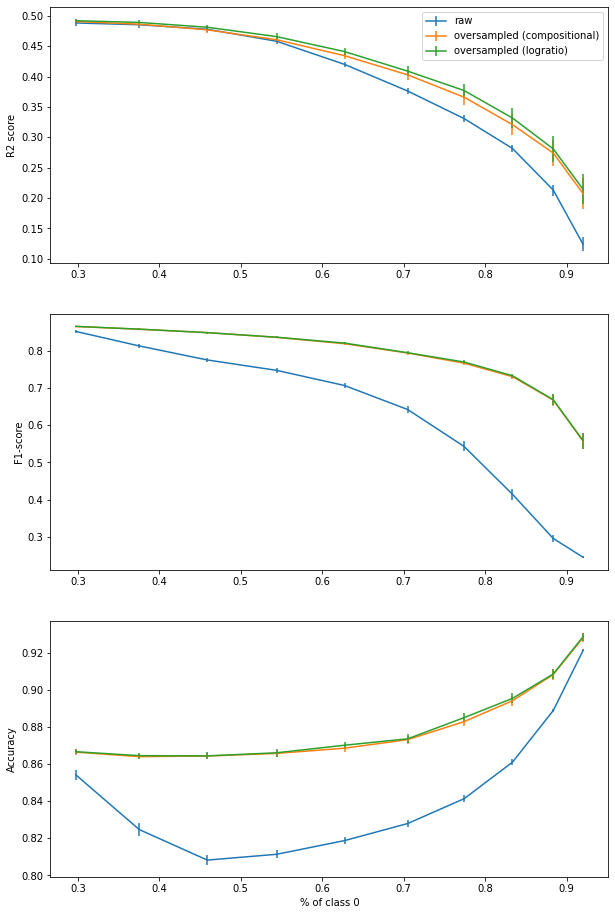

In [10]:
nrepet = 100

fig, ax = plt.subplots(3, 1, figsize=(10, 16))

ax[0].errorbar(np.array(imbalance_ratio_tot_dirichlet),np.mean(r2_raw_tot_dirichlet,axis=1),1.96*np.array(np.mean(r2_raw_std_dirichlet,axis=1))/np.sqrt(nrepet),label='raw')
ax[0].errorbar(np.array(imbalance_ratio_tot_dirichlet),np.mean(r2_compositional_tot_dirichlet,axis=1),1.96*np.array(np.mean(r2_compositional_std_dirichlet,axis=1))/np.sqrt(nrepet),label='oversampled (compositional)')
ax[0].errorbar(np.array(imbalance_ratio_tot_dirichlet),np.mean(r2_logratio_tot_dirichlet,axis=1),1.96*np.array(np.mean(r2_logratio_std_dirichlet,axis=1))/np.sqrt(nrepet),label='oversampled (logratio)')
#ax[0].set_xlabel('% of class 0')
ax[0].set_ylabel('R2 score')
ax[0].legend()
#ax[0].set_title('R2 score depending on the imbalance of the dataset, with Dirichlet model')

ax[1].errorbar(np.array(imbalance_ratio_tot_dirichlet),np.mean(f1_raw_tot_dirichlet,axis=1),1.96*np.array(np.mean(f1_raw_std_dirichlet,axis=1))/np.sqrt(nrepet),label='raw')
ax[1].errorbar(np.array(imbalance_ratio_tot_dirichlet),np.mean(f1_compositional_tot_dirichlet,axis=1),1.96*np.array(np.mean(f1_compositional_std_dirichlet,axis=1))/np.sqrt(nrepet),label='oversampled (compositional)')
ax[1].errorbar(np.array(imbalance_ratio_tot_dirichlet),np.mean(f1_logratio_tot_dirichlet,axis=1),1.96*np.array(np.mean(f1_logratio_std_dirichlet,axis=1))/np.sqrt(nrepet),label='oversampled (logratio)')
#ax[1].set_xlabel('% of class 0')
ax[1].set_ylabel('F1-score')
#ax[1].legend()
#ax[1].set_title('F1 score depending on the imbalance of the dataset, with Dirichlet model')

ax[2].errorbar(np.array(imbalance_ratio_tot_dirichlet),accuracy_raw_tot_dirichlet,1.96*np.array(accuracy_raw_std_dirichlet)/np.sqrt(nrepet),label='raw')
ax[2].errorbar(np.array(imbalance_ratio_tot_dirichlet),accuracy_compositional_tot_dirichlet,1.96*np.array(accuracy_compositional_std_dirichlet)/np.sqrt(nrepet),label='oversampled (compositional)')
ax[2].errorbar(np.array(imbalance_ratio_tot_dirichlet),accuracy_logratio_tot_dirichlet,1.96*np.array(accuracy_logratio_std_dirichlet)/np.sqrt(nrepet),label='oversampled (logratio)')
ax[2].set_xlabel('% of class 0')
ax[2].set_ylabel('Accuracy')
#ax[2].legend()
#ax[2].set_title('Accuracy depending on the imbalance of the dataset, with Dirichlet model')

plt.savefig('all_errorbars_4classes.jpg',dpi=250,bbox_inches='tight')
plt.show()

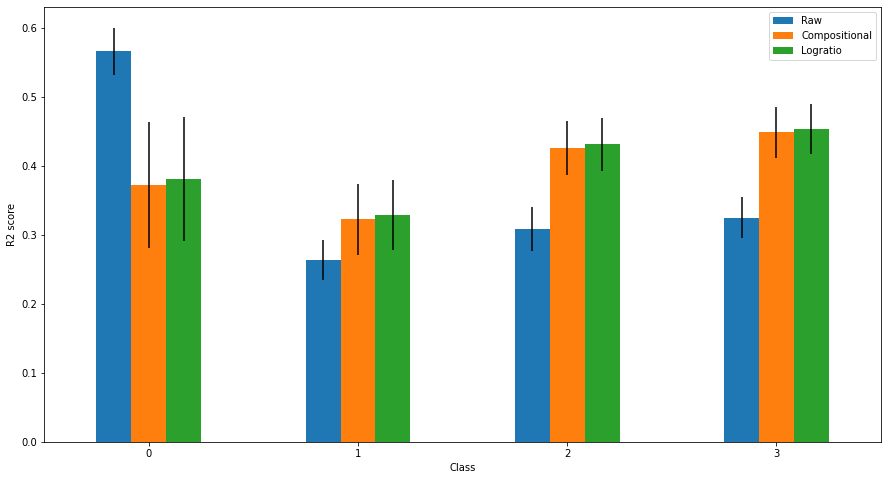

In [18]:
plotdata = pd.DataFrame({ "Raw": np.mean(r2_raw_tot_dirichlet, axis=0), 
                         "Compositional": np.mean(r2_compositional_tot_dirichlet, axis=0), 
                         "Logratio": np.mean(r2_logratio_tot_dirichlet, axis=0)},

    index=[0, 1, 2, 3])

errordata = pd.DataFrame({ "Raw": np.mean(r2_raw_std_dirichlet, axis=0), 
                         "Compositional": np.mean(r2_compositional_std_dirichlet, axis=0), 
                         "Logratio": np.mean(r2_logratio_std_dirichlet, axis=0)},

    index=[0, 1, 2, 3])

plotdata.plot(kind="bar",figsize=(15, 8), yerr=errordata)

#plt.title("Average R2 score per class with Dirichlet model")

plt.xlabel("Class")

plt.ylabel("R2 score")

plt.tick_params(axis="x", rotation=0)

#plt.savefig('r2_per_class.jpg',dpi=200,bbox_inches='tight')

plt.show()

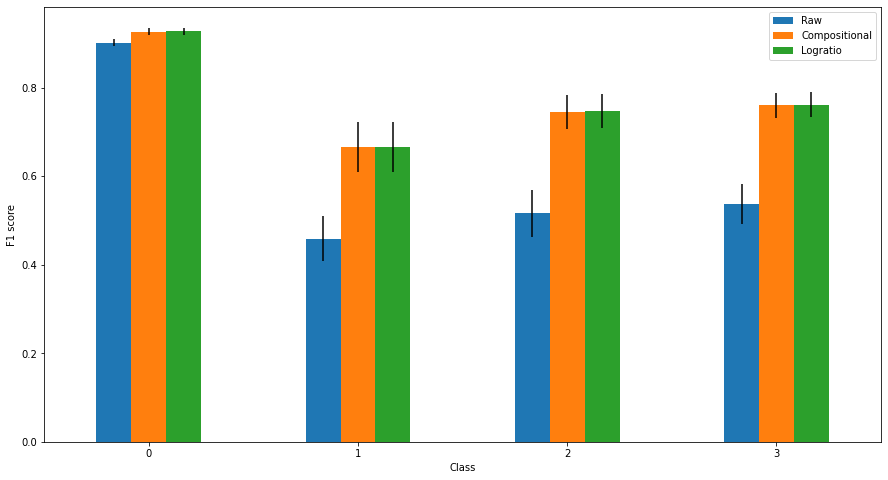

In [102]:
plotdata = pd.DataFrame({ "Raw": np.mean(f1_raw_tot_dirichlet, axis=0), 
                         "Compositional": np.mean(f1_compositional_tot_dirichlet, axis=0), 
                         "Logratio": np.mean(f1_logratio_tot_dirichlet, axis=0)},

    index=[0, 1, 2, 3])

errordata = pd.DataFrame({ "Raw": np.mean(f1_raw_std_dirichlet, axis=0), 
                         "Compositional": np.mean(f1_compositional_std_dirichlet, axis=0), 
                         "Logratio": np.mean(f1_logratio_std_dirichlet, axis=0)},

    index=[0, 1, 2, 3])

plotdata.plot(kind="bar",figsize=(15, 8), yerr=errordata)

#plt.title("Average F1 score per class with Dirichlet model")

plt.xlabel("Class")

plt.ylabel("F1 score")

plt.tick_params(axis="x", rotation=0)

plt.savefig('f1_per_class.jpg',dpi=200,bbox_inches='tight')

plt.show()

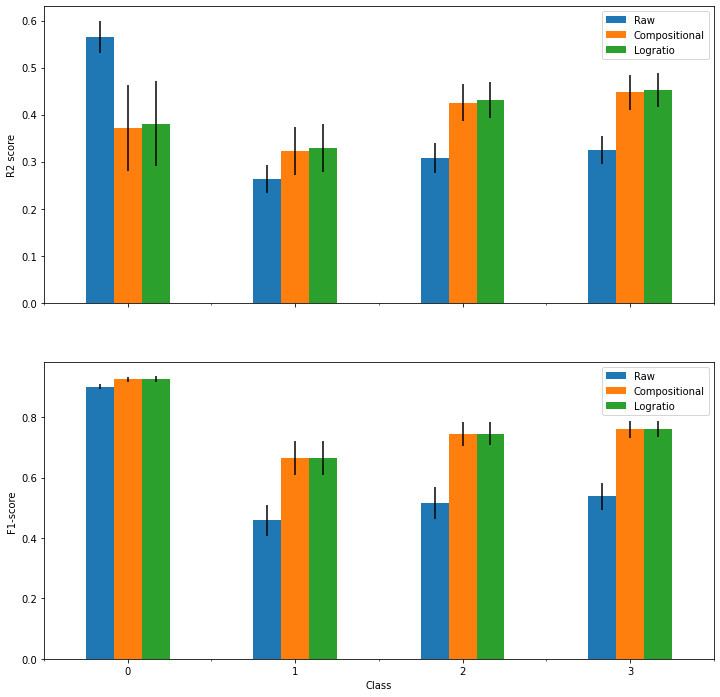

In [31]:
fig,ax = plt.subplots(2,1,figsize=(12,12),sharex=True)

plotdata = pd.DataFrame({ "Raw": np.mean(r2_raw_tot_dirichlet, axis=0), 
                         "Compositional": np.mean(r2_compositional_tot_dirichlet, axis=0), 
                         "Logratio": np.mean(r2_logratio_tot_dirichlet, axis=0)},

    index=[0, 1, 2, 3])

errordata = pd.DataFrame({ "Raw": np.mean(r2_raw_std_dirichlet, axis=0), 
                         "Compositional": np.mean(r2_compositional_std_dirichlet, axis=0), 
                         "Logratio": np.mean(r2_logratio_std_dirichlet, axis=0)},

    index=[0, 1, 2, 3])

plotdata.plot(kind="bar", yerr=errordata, ax=ax[0])

ax[0].set_ylabel("R2 score")


plotdata = pd.DataFrame({ "Raw": np.mean(f1_raw_tot_dirichlet, axis=0), 
                         "Compositional": np.mean(f1_compositional_tot_dirichlet, axis=0), 
                         "Logratio": np.mean(f1_logratio_tot_dirichlet, axis=0)},

    index=[0, 1, 2, 3])

errordata = pd.DataFrame({ "Raw": np.mean(f1_raw_std_dirichlet, axis=0), 
                         "Compositional": np.mean(f1_compositional_std_dirichlet, axis=0), 
                         "Logratio": np.mean(f1_logratio_std_dirichlet, axis=0)},

    index=[0, 1, 2, 3])

plotdata.plot(kind="bar", ax=ax[1], yerr=errordata)

ax[1].set_ylabel("F1-score")

ax[1].tick_params(axis="x", rotation=0)

ax[1].set_xlabel("Class")

plt.savefig('r2_and_f1_per_class.jpg',dpi=200,bbox_inches='tight')

plt.show()

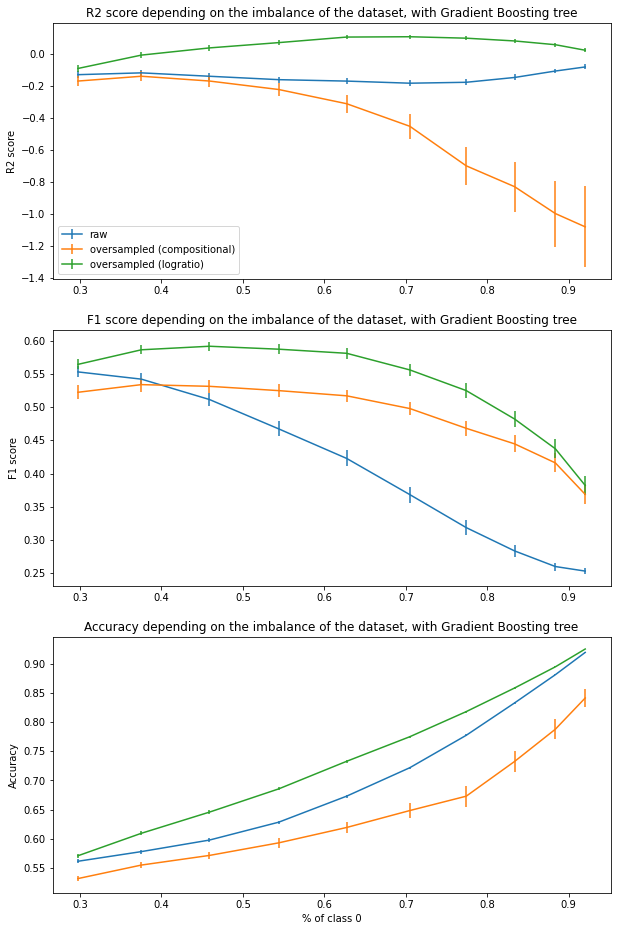

In [32]:
nrepet = 100

fig, ax = plt.subplots(3, 1, figsize=(10, 16))

ax[0].errorbar(np.array(imbalance_ratio_tot_gb),np.mean(r2_raw_tot_gb,axis=1),1.96*np.array(np.mean(r2_raw_std_gb,axis=1))/np.sqrt(nrepet),label='raw')
ax[0].errorbar(np.array(imbalance_ratio_tot_gb),np.mean(r2_compositional_tot_gb,axis=1),1.96*np.array(np.mean(r2_compositional_std_gb,axis=1))/np.sqrt(nrepet),label='oversampled (compositional)')
ax[0].errorbar(np.array(imbalance_ratio_tot_gb),np.mean(r2_logratio_tot_gb,axis=1),1.96*np.array(np.mean(r2_logratio_std_gb,axis=1))/np.sqrt(nrepet),label='oversampled (logratio)')
#ax[0].set_xlabel('% of class 0')
ax[0].set_ylabel('R2 score')
ax[0].legend()
ax[0].set_title('R2 score depending on the imbalance of the dataset, with Gradient Boosting tree')

ax[1].errorbar(np.array(imbalance_ratio_tot_gb),np.mean(f1_raw_tot_gb,axis=1),1.96*np.array(np.mean(f1_raw_std_gb,axis=1))/np.sqrt(nrepet),label='raw')
ax[1].errorbar(np.array(imbalance_ratio_tot_gb),np.mean(f1_compositional_tot_gb,axis=1),1.96*np.array(np.mean(f1_compositional_std_gb,axis=1))/np.sqrt(nrepet),label='oversampled (compositional)')
ax[1].errorbar(np.array(imbalance_ratio_tot_gb),np.mean(f1_logratio_tot_gb,axis=1),1.96*np.array(np.mean(f1_logratio_std_gb,axis=1))/np.sqrt(nrepet),label='oversampled (logratio)')
#ax[1].set_xlabel('% of class 0')
ax[1].set_ylabel('F1 score')
#ax[1].legend()
ax[1].set_title('F1 score depending on the imbalance of the dataset, with Gradient Boosting tree')

ax[2].errorbar(np.array(imbalance_ratio_tot_gb),accuracy_raw_tot_gb,1.96*np.array(accuracy_raw_std_gb)/np.sqrt(nrepet),label='raw')
ax[2].errorbar(np.array(imbalance_ratio_tot_gb),accuracy_compositional_tot_gb,1.96*np.array(accuracy_compositional_std_gb)/np.sqrt(nrepet),label='oversampled (compositional)')
ax[2].errorbar(np.array(imbalance_ratio_tot_gb),accuracy_logratio_tot_gb,1.96*np.array(accuracy_logratio_std_gb)/np.sqrt(nrepet),label='oversampled (logratio)')
ax[2].set_xlabel('% of class 0')
ax[2].set_ylabel('Accuracy')
#ax[2].legend()
ax[2].set_title('Accuracy depending on the imbalance of the dataset, with Gradient Boosting tree')

#plt.savefig('all_errorbars_4classes.jpg',dpi=250,bbox_inches='tight')
plt.show()

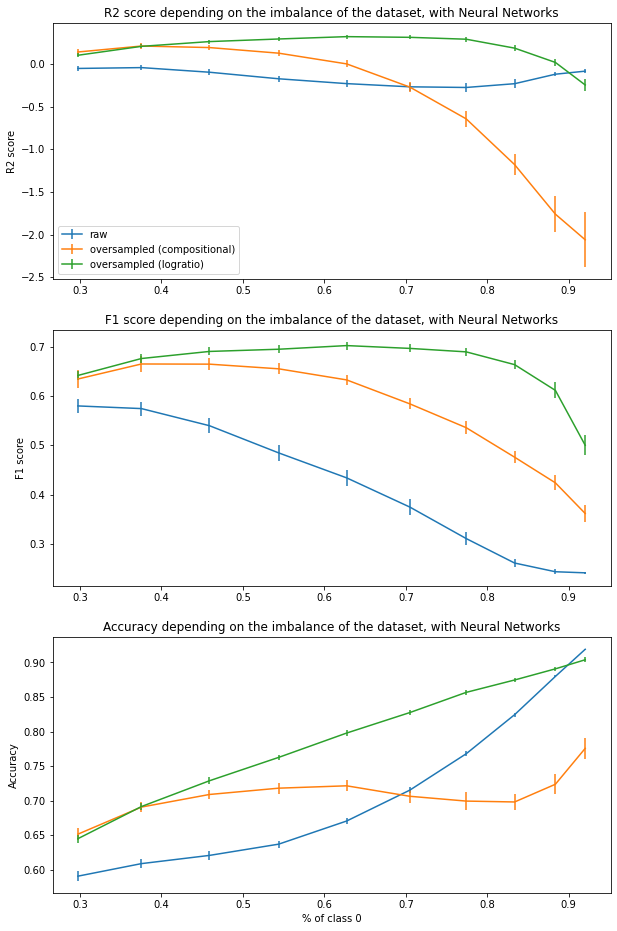

In [33]:
nrepet = 100

fig, ax = plt.subplots(3, 1, figsize=(10, 16))

ax[0].errorbar(np.array(imbalance_ratio_tot_nn),np.mean(r2_raw_tot_nn,axis=1),1.96*np.array(np.mean(r2_raw_std_nn,axis=1))/np.sqrt(nrepet),label='raw')
ax[0].errorbar(np.array(imbalance_ratio_tot_nn),np.mean(r2_compositional_tot_nn,axis=1),1.96*np.array(np.mean(r2_compositional_std_nn,axis=1))/np.sqrt(nrepet),label='oversampled (compositional)')
ax[0].errorbar(np.array(imbalance_ratio_tot_nn),np.mean(r2_logratio_tot_nn,axis=1),1.96*np.array(np.mean(r2_logratio_std_nn,axis=1))/np.sqrt(nrepet),label='oversampled (logratio)')
#ax[0].set_xlabel('% of class 0')
ax[0].set_ylabel('R2 score')
ax[0].legend()
ax[0].set_title('R2 score depending on the imbalance of the dataset, with Neural Networks')

ax[1].errorbar(np.array(imbalance_ratio_tot_nn),np.mean(f1_raw_tot_nn,axis=1),1.96*np.array(np.mean(f1_raw_std_nn,axis=1))/np.sqrt(nrepet),label='raw')
ax[1].errorbar(np.array(imbalance_ratio_tot_nn),np.mean(f1_compositional_tot_nn,axis=1),1.96*np.array(np.mean(f1_compositional_std_nn,axis=1))/np.sqrt(nrepet),label='oversampled (compositional)')
ax[1].errorbar(np.array(imbalance_ratio_tot_nn),np.mean(f1_logratio_tot_nn,axis=1),1.96*np.array(np.mean(f1_logratio_std_nn,axis=1))/np.sqrt(nrepet),label='oversampled (logratio)')
#ax[1].set_xlabel('% of class 0')
ax[1].set_ylabel('F1 score')
#ax[1].legend()
ax[1].set_title('F1 score depending on the imbalance of the dataset, with Neural Networks')

ax[2].errorbar(np.array(imbalance_ratio_tot_nn),accuracy_raw_tot_nn,1.96*np.array(accuracy_raw_std_nn)/np.sqrt(nrepet),label='raw')
ax[2].errorbar(np.array(imbalance_ratio_tot_nn),accuracy_compositional_tot_nn,1.96*np.array(accuracy_compositional_std_nn)/np.sqrt(nrepet),label='oversampled (compositional)')
ax[2].errorbar(np.array(imbalance_ratio_tot_nn),accuracy_logratio_tot_nn,1.96*np.array(accuracy_logratio_std_nn)/np.sqrt(nrepet),label='oversampled (logratio)')
ax[2].set_xlabel('% of class 0')
ax[2].set_ylabel('Accuracy')
#ax[2].legend()
ax[2].set_title('Accuracy depending on the imbalance of the dataset, with Neural Networks')

#plt.savefig('all_errorbars_4classes.jpg',dpi=250,bbox_inches='tight')
plt.show()